# Business Understanding

Task 1:
Through EDA find at least 3 useful insights in the dataset, that could be used as recommendations for house sellers and/or buyers

Task 2:
Model the dataset with a multivariate linear regression to predict the sale price of houses as accurately as possible (R-squared: 0.7 to 0.9)

# Data Mining

In [100]:
reset -fs

In [101]:
# Importing the most important packages and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn')

In [102]:
# Importing the dataset and first glance
df = pd.read_csv("/Users/tjadeappel/nf-sep-20/2020-ds-Project-EDA/King_County_House_prices_dataset.csv", na_values="?")
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Data Cleaning

Key Questions:  
1. What types of data does the dataset contain?
2. Do any values have to converted in their type?
3. Are their missing values? If yes, how many and how should they be handled?
4. Are their outliers? If yes, how should they be handled?

In [103]:
# What types of data does the dataset contain
df.info()
print(type(df.date[3]))
# Date is saved as a string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21143 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB
<class 'str

In [104]:
# Check for missing values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
missing[missing.Number!=0]

,Number,Percentage
waterfront,2376,11.0
view,63,0.3
sqft_basement,454,2.1
yr_renovated,3842,17.8


0.0    19075
1.0      146
Name: waterfront, dtype: int64


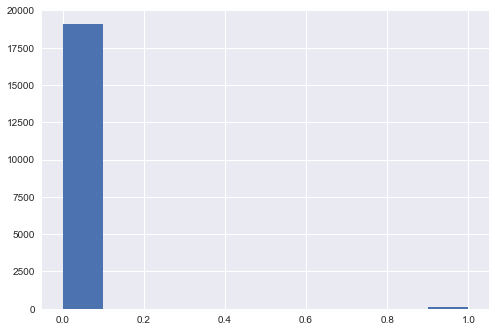

In [105]:
# What is the distribution of houses with a waterfront?
print(df.waterfront.value_counts())
df.waterfront.hist();

In [106]:
# Only very few houses have waterfronts --> assumption: houses with no value in column don't have a waterfront
# Therefore those are replaced with 0.
df.waterfront.fillna(value = 0, inplace = True)

0.0


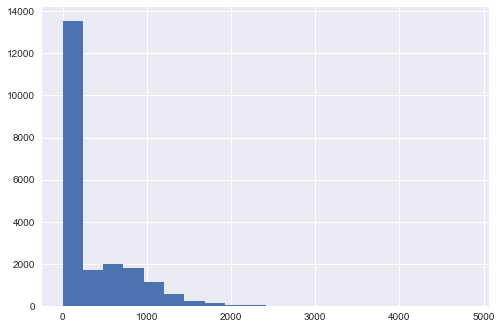

In [107]:
# What is the distribution of sqft_basement values?
df.sqft_basement.hist(bins = 20)
print(df.sqft_basement.median())

In [108]:
# Most houses dont seem to have a basement. Therefore the assumption is that missing values can be filled with the median 0.
df.sqft_basement.fillna(value = 0, inplace = True)

# Dropping rows with missing columns for view due to very small percentage of missing values
df.dropna(subset = ["view"], inplace=True)

# The column id will  probably not have much information, which is why it will be dropped
df.drop("id", axis = 1, inplace = True)

In [109]:
# Yr_built and yr_renovated can probably merged into a new feature (age_lastchange) and the respective columns dropped
df["yr_lastchange"] = df[["yr_built", "yr_renovated"]].max(axis=1)
df['sales_yr']=df['date'].astype(str).str[-4:]
df['age_lastchange']=df['sales_yr'].astype(int)-df['yr_lastchange']
df.drop(['yr_lastchange',"yr_built", "yr_renovated","sales_yr","date"], axis = 1, inplace = True)

# Data Exploration

1. Which features are continuous variables and which categorical?
2. Check for correlations between features and label
3. Check for correlation between features
4. What recommendations can be made to potential house sellers/buyers

## 3 Recommendations

### Best price / sq ft living area

In [110]:
# Adding column for the searched feature
df["price_per_sqft_living"] = df["price"]/df["sqft_living"]

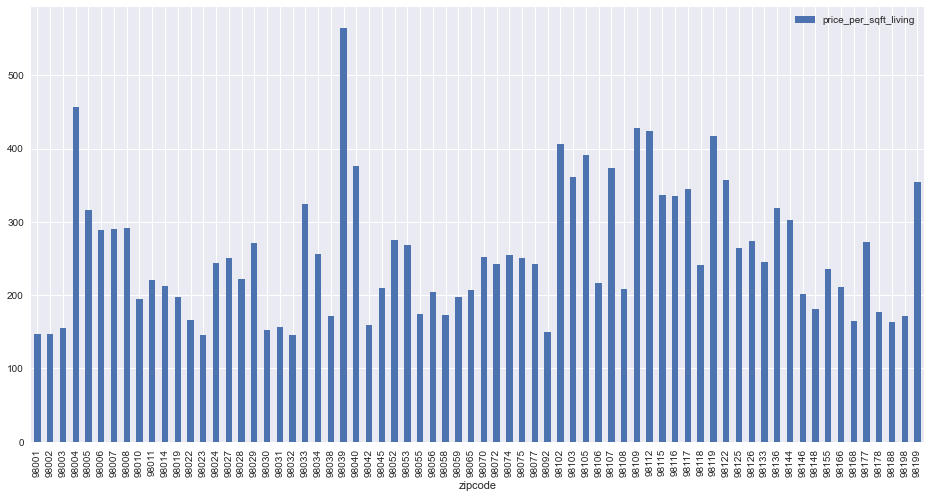

In [111]:
# Plotting a barchart for the median price / sq ft by zipcode 
median_price_per_sqft_living_by_zipcode = df.groupby("zipcode").median()["price_per_sqft_living"].reset_index()
median_price_per_sqft_living_by_zipcode.plot(kind = "bar", x = "zipcode", y = "price_per_sqft_living", figsize = (16,8));

In [112]:
# Grabbing the 3 cheapest zipcodes
median_price_per_sqft_living_by_zipcode.sort_values(["price_per_sqft_living"], ascending = True, inplace = True)
median_price_per_sqft_living_by_zipcode.head(3)

,zipcode,price_per_sqft_living
13,98023,144.886364
20,98032,146.202094
0,98001,146.759259


In [113]:
# Removing the column again (not useful in regression later)
df.drop("price_per_sqft_living", axis = 1, inplace = True)

### Value of King County grade for sellers

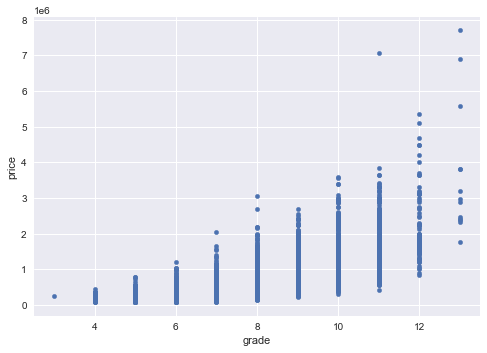

In [114]:
# Plotting all data points
df.plot(x = "grade", y = "price", kind = "scatter");

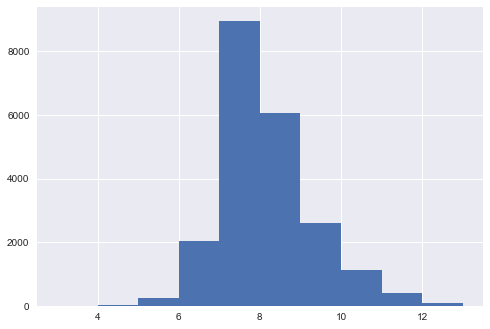

In [115]:
# Distribution of given grades
df.grade.hist();

In [116]:
# Checking the median price in King County and the median price grouped by grade categories
print(df.price.median())
df.groupby("grade").median()["price"]


450000.0


grade
3      262000.0
4      200000.0
5      228700.0
6      275500.0
7      375000.0
8      510000.0
9      721750.0
10     913077.0
11    1280000.0
12    1820000.0
13    2980000.0
Name: price, dtype: float64

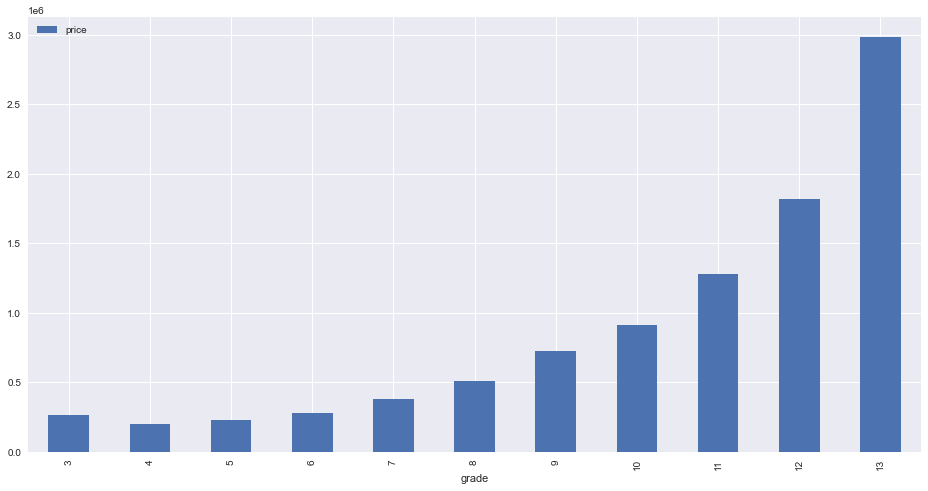

In [117]:
# Visualizing median price by grade as barplot
median_price_by_grade = df.groupby("grade").median()["price"].reset_index()
median_price_by_grade.plot(kind = "bar", x = "grade", y = "price", figsize = (16,8));

In [118]:
# Checking the grade feature for correlation with other indicators of a quality house
df.corr()["grade"]

price             0.668307
bedrooms          0.356095
bathrooms         0.665312
sqft_living       0.762398
sqft_lot          0.115122
floors            0.458694
waterfront        0.081195
view              0.249727
condition        -0.147326
grade             1.000000
sqft_above        0.755977
sqft_basement     0.164272
zipcode          -0.185710
lat               0.113787
long              0.200821
sqft_living15     0.713462
sqft_lot15        0.121435
age_lastchange   -0.459879
Name: grade, dtype: float64

### Rich, old golf player wants house near downtown

In [119]:
# Zipcodes for 5 best golf clubs are taken from google maps and some metrics compared
zipcodes_golf_clubs = [98126, 98108, 98039, 98112, 98119]
df["price_per_sqft_living"] = df["price"]/df["sqft_living"]
df_zipcodes_golf_clubs = df.copy()
df_zipcodes_golf_clubs = df_zipcodes_golf_clubs.loc[df_zipcodes_golf_clubs['zipcode'].isin(zipcodes_golf_clubs)]

df_zipcodes_golf_clubs.groupby("zipcode").median().reset_index()[["zipcode","price_per_sqft_living", "age_lastchange", "sqft_basement","floors"]]

,zipcode,price_per_sqft_living,age_lastchange,sqft_basement,floors
0,98039,565.165614,28.5,0.0,2.0
1,98108,208.301144,61.5,305.0,1.0
2,98112,424.581276,83.5,442.5,2.0
3,98119,416.652778,76.0,285.0,2.0
4,98126,274.390244,69.0,0.0,1.0


In [120]:
# Removing the column again (not useful in regression later)
df.drop("price_per_sqft_living", axis = 1, inplace = True)

## Checking for correlation using plots and correlation matrix

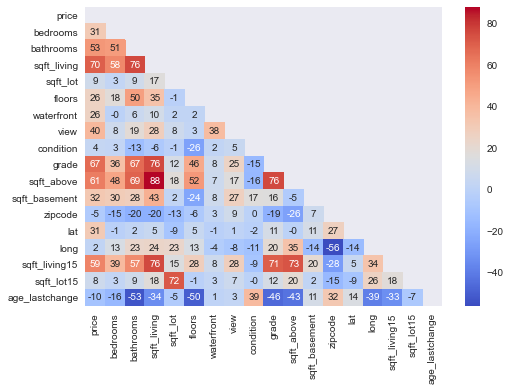

In [121]:
# Creating Heatmap for correlation coefficients of all variables
X_dum=pd.get_dummies(df.copy())
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')

1. Sqft_living, sqft_above, sqft_living15, bathrooms and view might be interesting features to consider.
2. They seem to have a good positive linear correlation with the price and the highest single R-squared values.
3. But there seems to be a lot of correlation between those features.

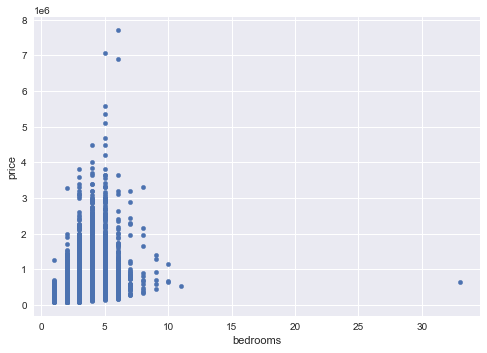

In [122]:
# Visualizing the data
df.plot(x = "bedrooms", y = "price", kind = "scatter");
# Might me even more useful without the outlier


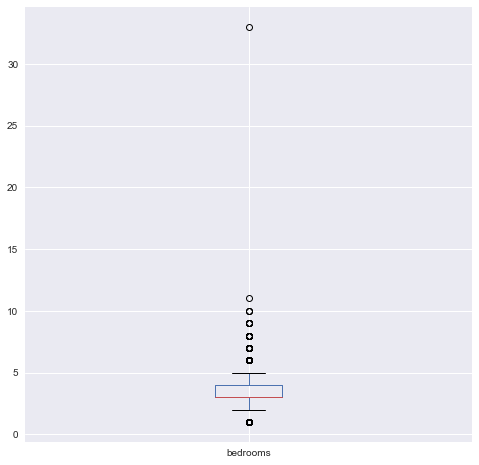

In [123]:
df.bedrooms.plot(kind='box',figsize=(8,8));
# Removing outlier with 33 bedrooms
df.drop(df[df['bedrooms'] == 33].index , inplace=True)

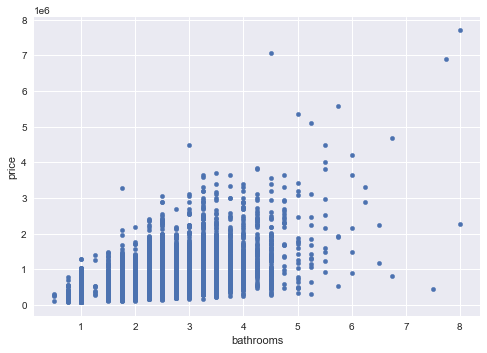

In [124]:
df.plot(x = "bathrooms", y = "price", kind = "scatter");

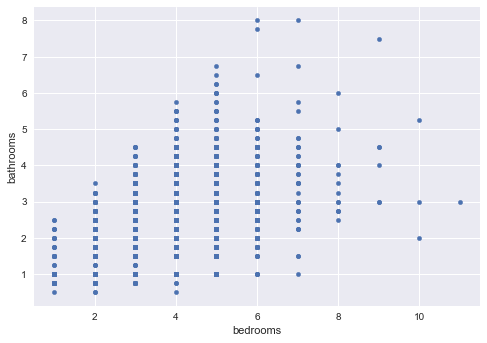

In [125]:
df.plot(x = "bedrooms", y = "bathrooms", kind = "scatter");

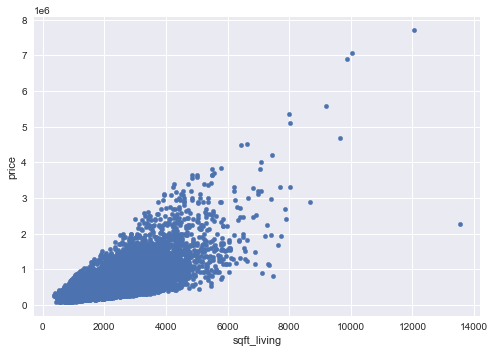

In [126]:
df.plot(x = "sqft_living", y = "price", kind = "scatter");

# Might be even more useful without the outlier

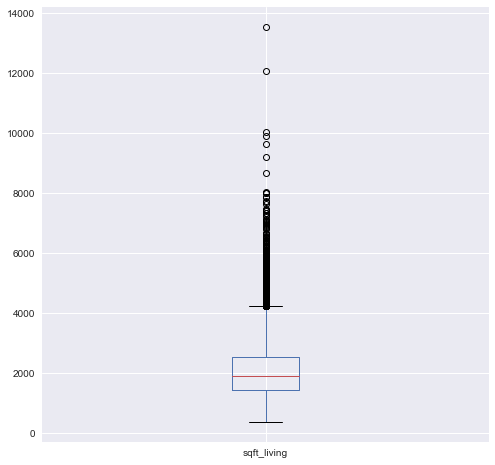

In [127]:
df.sqft_living.plot(kind='box',figsize=(8,8));
df.sqft_living.describe().round(2)

# Removing outlier
df.drop(df[df['sqft_living'] == 13540.00].index , inplace=True)

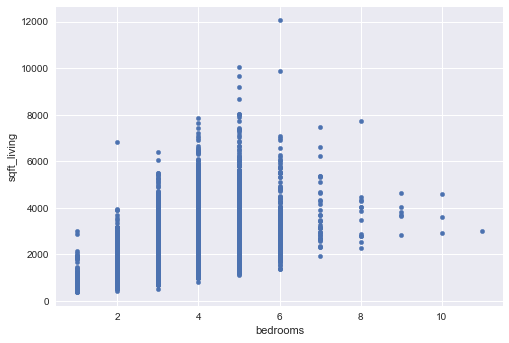

In [128]:
df.plot(x = "bedrooms", y = "sqft_living", kind = "scatter");

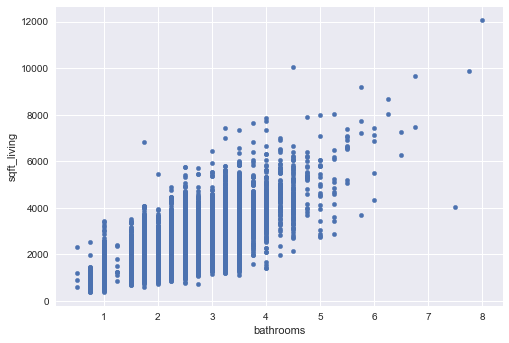

In [129]:
df.plot(x = "bathrooms", y = "sqft_living", kind = "scatter");

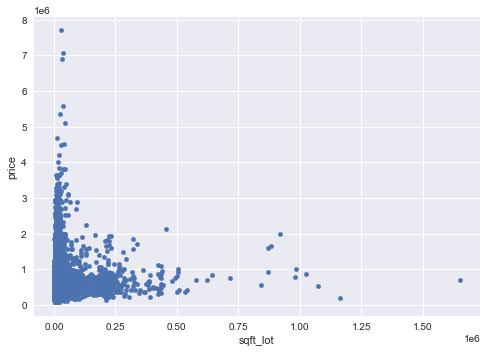

In [130]:
df.plot(x = "sqft_lot", y = "price", kind = "scatter");

# Not very useful

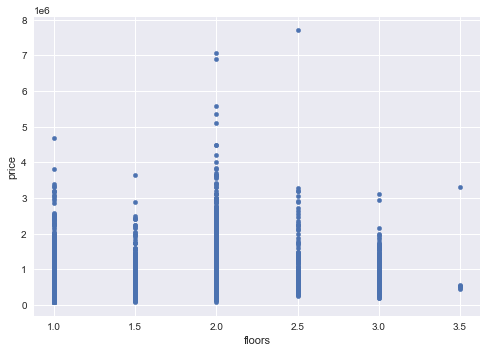

In [131]:
df.plot(x = "floors", y = "price", kind = "scatter");

# Maybe somewhat of a quadratic correlation

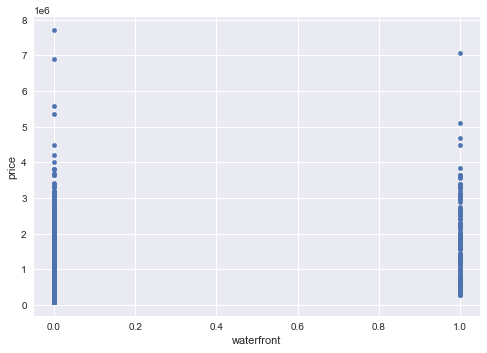

In [132]:
df.plot(x = "waterfront", y = "price", kind = "scatter");

# Not insightful, but useful categorical variable

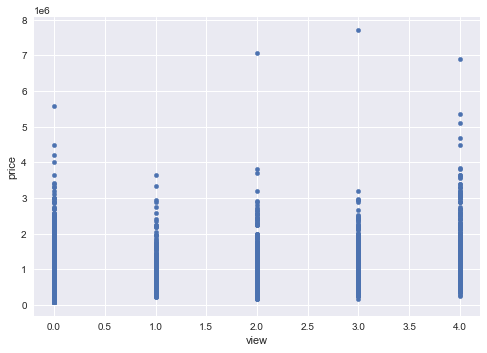

In [133]:
df.plot(x = "view", y = "price", kind = "scatter");

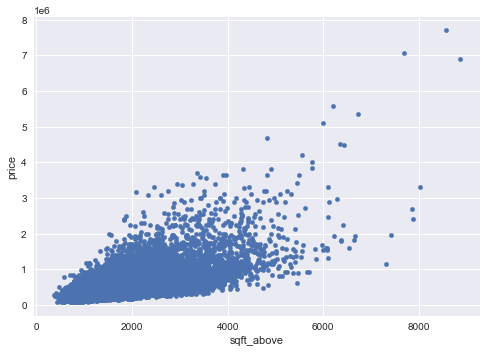

In [134]:
df.plot(x = "sqft_above", y = "price", kind = "scatter");

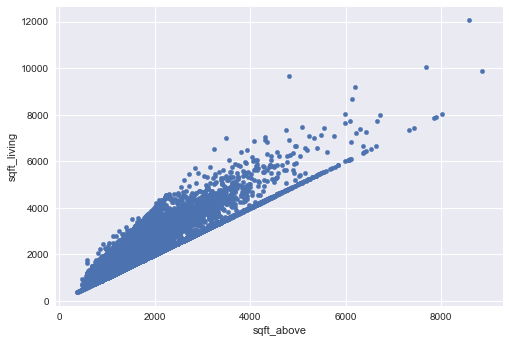

In [135]:
df.plot(x = "sqft_above", y = "sqft_living", kind = "scatter");
# Column can probably be dropped

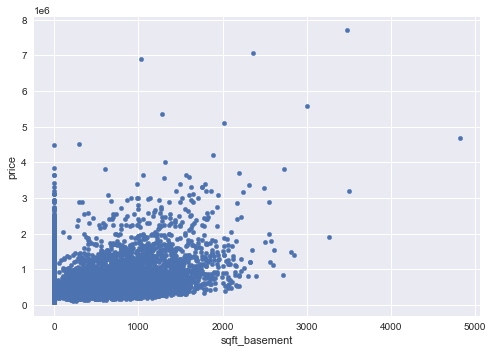

In [136]:
df.plot(x = "sqft_basement", y = "price", kind = "scatter");

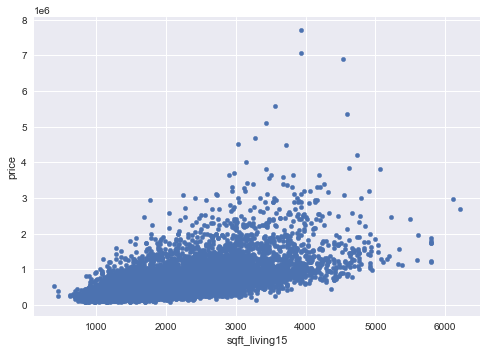

In [137]:
df.plot(x = "sqft_living15", y = "price", kind = "scatter");
# Seems useful but Multicolinearity with sqft_living and grade

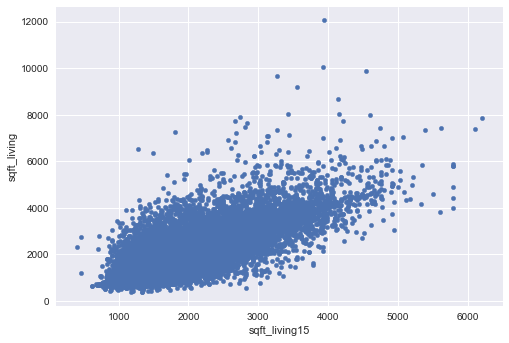

In [138]:
df.plot(x = "sqft_living15", y = "sqft_living", kind = "scatter");

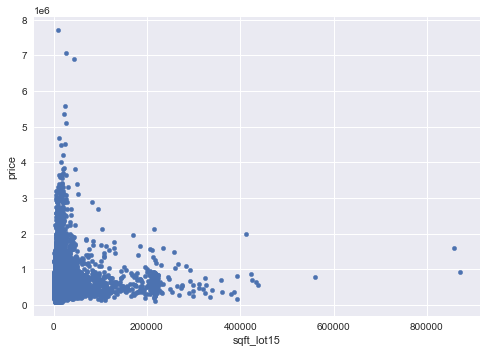

In [139]:
df.plot(x = "sqft_lot15", y = "price", kind = "scatter");
# Not useful

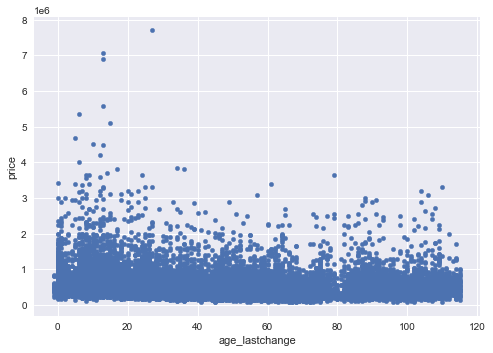

In [140]:
df.plot(x = "age_lastchange", y = "price", kind = "scatter");

## Splitting continuous and categorical variables

In [141]:
# Converting categorical variables to Strings
df[["zipcode","bedrooms","bathrooms","floors","view","condition","grade"]] = df[["zipcode","bedrooms","bathrooms","floors","view","condition","grade"]].astype(str)

# Dividing into continuous and categorical variables.
continuous_var = list(df.select_dtypes(
                        ['int64','float64','bool']).columns.values)
categorical_var=list(df.select_dtypes(
                        ['object']).columns.values)
categorical_var

['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'zipcode']

In [142]:
# Checking R-squared for single continuous variables
print('R squared for each possible continuous explanatory variable:' )
for explanatory_var in continuous_var:
    model = 'price ~ {:}'.format(explanatory_var)
    rs = smf.ols(formula=model, data=df).fit().rsquared
    print('{:7s} \t \t= {:.3}'.format(explanatory_var, rs))

R squared for each possible continuous explanatory variable:
price   	 	= 1.0
sqft_living 	 	= 0.492
sqft_lot 	 	= 0.00791
waterfront 	 	= 0.0673
sqft_above 	 	= 0.366
sqft_basement 	 	= 0.101
lat     	 	= 0.0948
long    	 	= 0.000488
sqft_living15 	 	= 0.342
sqft_lot15 	 	= 0.00667
age_lastchange 	 	= 0.00953


# Feature Programming

Only new feature of age_lastchange was created earlier.

# Predictive Modelling

## First linear regression model

In [143]:
# First try for model 
# Includes all features

X_modell1 = pd.get_dummies(df.copy(), drop_first = True)
X_modell1.drop("price", axis=1, inplace = True)
X_modell1 = sms.add_constant(X_modell1)
y_modell1 = df["price"]
model_modell1 = sms.OLS(y_modell1, X_modell1)
results_modell1 = model_modell1.fit()
results_modell1.summary()

# result is probably overfitted (very high Cond.No)

/Users/tjadeappel/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     829.4
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        08:10:40   Log-Likelihood:            -2.8635e+05
No. Observations:               21532   AIC:                         5.730e+05
Df Residuals:                   21391   BIC:                         5.741e+05
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.526e+07   5.56e+06     -6.343      0.000   -4.62e+07   -2.44e+07
sqft_living      100.9357     13.091      7.710      0.000      75.276     126.595
sqft_lot           0.2605      0.035      7.489      0.000       0.192       0.329
waterfront      5.779e+05   1.51e+04     38.280      0.000    5.48e+05    6.08e+05
sqft_above        56.7952     13.147      4.320      0.000      31.027      82.563
sqft_basement     13.1629     12.956      1.016      0.310     -12.233      38.558
lat             2.088e+05   5.73e+04      3.643      0.000    9.65e+04    3.21e+05
long           -2.077e+05   4.13e+04     -5.030      0.000   -2.89e+05   -1.27e+05
sqft_living15     21.7877      2.675      8.145      0.000      16.545      27.031
sqft_lot15        -0.1505      0.055     -2.748      0.006      -0.258      -0.043
age_lastchange  -112.6475     60.478     -1.863      0.063    -231.190       5.895
bedrooms_10    -3.167e+05   8.57e+04     -3.693      0.000   -4.85e+05   -1.49e+05
bedrooms_11    -8856.1365   1.46e+05     -0.061      0.951   -2.94e+05    2.77e+05
bedrooms_2      5109.5101   1.12e+04      0.458      0.647   -1.68e+04     2.7e+04
bedrooms_3      1.397e+04   1.12e+04      1.248      0.212   -7967.874    3.59e+04
bedrooms_4     -1039.2059   1.14e+04     -0.091      0.928   -2.35e+04    2.14e+04
bedrooms_5     -1.482e+04   1.21e+04     -1.229      0.219   -3.85e+04    8819.896
bedrooms_6     -6.115e+04   1.47e+04     -4.156      0.000      -9e+04   -3.23e+04
bedrooms_7     -1.229e+05    2.7e+04     -4.544      0.000   -1.76e+05   -6.99e+04
bedrooms_8     -3.577e+04   4.27e+04     -0.838      0.402   -1.19e+05    4.79e+04
bedrooms_9     -1.483e+05   6.67e+04     -2.224      0.026   -2.79e+05   -1.76e+04
bathrooms_0.75  8209.9159   7.48e+04      0.110      0.913   -1.38e+05    1.55e+05
bathrooms_1.0   3.582e+04   7.26e+04      0.493      0.622   -1.06e+05    1.78e+05
bathrooms_1.25 -6.321e+04   8.72e+04     -0.725      0.469   -2.34e+05    1.08e+05
bathrooms_1.5   2.505e+04   7.27e+04      0.345      0.730   -1.17e+05    1.68e+05
bathrooms_1.75  2.307e+04   7.27e+04      0.318      0.751   -1.19e+05    1.65e+05
bathrooms_2.0   2.448e+04   7.27e+04      0.337      0.736   -1.18e+05    1.67e+05
bathrooms_2.25  3.884e+04   7.27e+04      0.534      0.593   -1.04e+05    1.81e+05
bathrooms_2.5   2.668e+04   7.27e+04      0.367      0.714   -1.16e+05    1.69e+05
bathrooms_2.75  2.733e+04   7.28e+04      0.376      0.707   -1.15e+05     1.7e+05
bathrooms_3.0   4.785e+04   7.29e+04      0.657      0.511    -9.5e+04    1.91e+05
bathrooms_3.25  8.755e+04    7.3e+04      1.200      0.230   -5.54e+04    2.31e+05
bathrooms_3.5    4.42e+04   7.29e+04      0.606      0.544   -9.87e+04    1.87e+05
bathrooms_3.75  1.231e+05   7.37e+04      1.671      0.095   -2.13e+04    2.68e+05
bathrooms_4.

### Checking RMSE for Train-Test-Split and KFold-Crossvalidation

In [144]:
# Testing the model with RepeatedKfold Cross-Validation
MSE = []
rkf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=42)
X_modell1 = X_modell1.values
y_modell1 = y_modell1.values
for train_index, test_index in rkf.split(X_modell1):
    X_train, X_test = X_modell1[train_index,:], X_modell1[test_index,:]
    y_train, y_test = y_modell1[train_index], y_modell1[test_index]
    
    X_train = sms.add_constant(X_train)
    
    model_Rkfold = sms.OLS(y_train, X_train)
    results_Rkfold = model_Rkfold.fit()
    
    #results_modell1.summary()
    y_true = y_test
    y_pred = results_Rkfold.predict(X_test)
    MSE.append(mean_squared_error(y_true, y_pred))
    
print("The RMSE for the model with the chosen parameters has a median of: "\
      + str (round(statistics.median(MSE)**0.5,2))+"$")

The RMSE for the model with the chosen parameters has a median of: 152830.88$


## Second linear regression model

In [145]:
# Second try for model 
# Includes  sqft_living, zipcode, view, age_lastchange, bedrooms, waterfront

X_modell2 = pd.get_dummies(df[["sqft_living", "zipcode", "view", "age_lastchange", "bedrooms","waterfront"]].copy(),
                           drop_first = True)
X_modell2 = sms.add_constant(X_modell2)
y_modell2 = df["price"]
model_modell2 = sms.OLS(y_modell2, X_modell2)
results_modell2 = model_modell2.fit()
results_modell2.summary()

/Users/tjadeappel/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     935.7
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        08:12:22   Log-Likelihood:            -2.8960e+05
No. Observations:               21532   AIC:                         5.794e+05
Df Residuals:                   21445   BIC:                         5.801e+05
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.403e+05   1.53e+04     -9.155      0.000    -1.7e+05    -1.1e+05
sqft_living      252.1668      1.862    135.404      0.000     248.517     255.817
age_lastchange   221.5672     47.853      4.630      0.000     127.771     315.364
waterfront      5.535e+05   1.74e+04     31.796      0.000    5.19e+05    5.88e+05
zipcode_98002   2.268e+04   1.49e+04      1.524      0.128   -6489.849    5.18e+04
zipcode_98003  -1256.2286   1.34e+04     -0.094      0.925   -2.76e+04     2.5e+04
zipcode_98004   8.226e+05   1.31e+04     62.840      0.000    7.97e+05    8.48e+05
zipcode_98005   3.525e+05   1.58e+04     22.335      0.000    3.22e+05    3.83e+05
zipcode_98006   3.075e+05   1.18e+04     26.167      0.000    2.84e+05    3.31e+05
zipcode_98007   2.844e+05   1.67e+04     16.985      0.000    2.52e+05    3.17e+05
zipcode_98008   2.711e+05   1.34e+04     20.213      0.000    2.45e+05    2.97e+05
zipcode_98010    8.08e+04    1.9e+04      4.247      0.000    4.35e+04    1.18e+05
zipcode_98011   1.281e+05    1.5e+04      8.542      0.000    9.87e+04    1.58e+05
zipcode_98014   1.033e+05   1.76e+04      5.888      0.000    6.89e+04    1.38e+05
zipcode_98019   8.229e+04   1.51e+04      5.447      0.000    5.27e+04    1.12e+05
zipcode_98022   1.492e+04   1.42e+04      1.049      0.294   -1.29e+04    4.28e+04
zipcode_98023  -2.116e+04   1.17e+04     -1.815      0.070    -4.4e+04    1697.383
zipcode_98024   1.797e+05   2.09e+04      8.587      0.000    1.39e+05    2.21e+05
zipcode_98027   1.819e+05   1.22e+04     14.902      0.000    1.58e+05    2.06e+05
zipcode_98028   1.217e+05   1.34e+04      9.090      0.000    9.55e+04    1.48e+05
zipcode_98029   2.419e+05   1.29e+04     18.679      0.000    2.16e+05    2.67e+05
zipcode_98030   9221.1711   1.38e+04      0.670      0.503   -1.77e+04    3.62e+04
zipcode_98031   2.159e+04   1.35e+04      1.598      0.110   -4887.764    4.81e+04
zipcode_98032   8030.1621   1.75e+04      0.458      0.647   -2.63e+04    4.24e+04
zipcode_98033   3.928e+05    1.2e+04     32.627      0.000    3.69e+05    4.16e+05
zipcode_98034   2.098e+05   1.14e+04     18.343      0.000    1.87e+05    2.32e+05
zipcode_98038   3.291e+04   1.13e+04      2.914      0.004    1.08e+04    5.51e+04
zipcode_98039   1.391e+06   2.56e+04     54.386      0.000    1.34e+06    1.44e+06
zipcode_98040   5.613e+05   1.36e+04     41.319      0.000    5.35e+05    5.88e+05
zipcode_98042   1.668e+04   1.14e+04      1.458      0.145   -5736.790    3.91e+04
zipcode_98045   1.041e+05   1.44e+04      7.219      0.000    7.58e+04    1.32e+05
zipcode_98052   2.561e+05   1.13e+04     22.577      0.000    2.34e+05    2.78e+05
zipcode_98053   2.187e+05   1.23e+04     17.742      0.000    1.95e+05    2.43e+05
zipcode_98055   4.506e+04   1.36e+04      3.315      0.001    1.84e+04    7.17e+04
zipcode_9805

### Checking RMSE for Train-Test-Split and KFold-Crossvalidation

In [146]:
# Testing the model with RepeatedKfold Cross-Validation
MSE = []
rkf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=42)
X_modell2 = X_modell2.values
y_modell2 = y_modell2.values
for train_index, test_index in rkf.split(X_modell2):
    X_train, X_test = X_modell2[train_index,:], X_modell2[test_index,:]
    y_train, y_test = y_modell2[train_index], y_modell2[test_index]
    
    X_train = sms.add_constant(X_train)
    
    model_Rkfold = sms.OLS(y_train, X_train)
    results_Rkfold = model_Rkfold.fit()
    
    #results_modell2.summary()
    y_true = y_test
    y_pred = results_Rkfold.predict(X_test)
    MSE.append(mean_squared_error(y_true, y_pred))
    
print("The RMSE for the model with the chosen parameters has a median of: "\
      + str (round(statistics.median(MSE)**0.5,2))+"$")

The RMSE for the model with the chosen parameters has a median of: 168695.45$


## Third linear regression model

In [148]:
# Third try for model 
# Includes only sqft_living, zipcode

X_modell3 = pd.get_dummies(df[["sqft_living", "zipcode"]].copy(),
                           drop_first = True)
X_modell3 = sms.add_constant(X_modell3)
y_modell3 = df["price"]
model_modell3 = sms.OLS(y_modell3, X_modell3)
results_modell3 = model_modell3.fit()
results_modell3.summary()

/Users/tjadeappel/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     832.9
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        08:13:43   Log-Likelihood:            -2.9224e+05
No. Observations:               21532   AIC:                         5.846e+05
Df Residuals:                   21461   BIC:                         5.852e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.989e+05   1.05e+04    -18.992      0.000   -2.19e+05   -1.78e+05
sqft_living     252.2605      1.574    160.220      0.000     249.174     255.347
zipcode_98002  2.252e+04   1.68e+04      1.340      0.180   -1.04e+04    5.55e+04
zipcode_98003  6384.1380   1.52e+04      0.421      0.674   -2.33e+04    3.61e+04
zipcode_98004  8.225e+05   1.47e+04     55.765      0.000    7.94e+05    8.51e+05
zipcode_98005  3.389e+05   1.78e+04     19.031      0.000    3.04e+05    3.74e+05
zipcode_98006  3.302e+05   1.33e+04     24.902      0.000    3.04e+05    3.56e+05
zipcode_98007  2.657e+05   1.89e+04     14.057      0.000    2.29e+05    3.03e+05
zipcode_98008  3.063e+05   1.51e+04     20.263      0.000    2.77e+05    3.36e+05
zipcode_98010  8.329e+04   2.15e+04      3.874      0.000    4.12e+04    1.25e+05
zipcode_98011  1.209e+05   1.69e+04      7.134      0.000    8.77e+04    1.54e+05
zipcode_98014  1.202e+05   1.98e+04      6.069      0.000    8.14e+04    1.59e+05
zipcode_98019  7.587e+04   1.71e+04      4.447      0.000    4.24e+04    1.09e+05
zipcode_98022  5.196e+04    1.6e+04      3.245      0.001    2.06e+04    8.33e+04
zipcode_98023  -1.64e+04   1.32e+04     -1.245      0.213   -4.22e+04    9429.541
zipcode_98024  1.894e+05   2.36e+04      8.011      0.000    1.43e+05    2.36e+05
zipcode_98027  1.813e+05   1.38e+04     13.152      0.000    1.54e+05    2.08e+05
zipcode_98028  1.263e+05   1.51e+04      8.348      0.000    9.67e+04    1.56e+05
zipcode_98029  2.353e+05   1.46e+04     16.099      0.000    2.07e+05    2.64e+05
zipcode_98030   -19.6168   1.56e+04     -0.001      0.999   -3.05e+04    3.05e+04
zipcode_98031  1.241e+04   1.53e+04      0.813      0.416   -1.75e+04    4.23e+04
zipcode_98032  1.133e+04   1.98e+04      0.572      0.567   -2.75e+04    5.01e+04
zipcode_98033  4.021e+05   1.36e+04     29.574      0.000    3.75e+05    4.29e+05
zipcode_98034  2.215e+05   1.29e+04     17.138      0.000    1.96e+05    2.47e+05
zipcode_98038   2.39e+04   1.27e+04      1.875      0.061   -1079.610    4.89e+04
zipcode_98039  1.401e+06   2.89e+04     48.573      0.000    1.34e+06    1.46e+06
zipcode_98040  6.008e+05   1.53e+04     39.296      0.000    5.71e+05    6.31e+05
zipcode_98042  1.129e+04   1.29e+04      0.874      0.382    -1.4e+04    3.66e+04
zipcode_98045  1.168e+05   1.63e+04      7.174      0.000    8.49e+04    1.49e+05
zipcode_98052  2.478e+05   1.28e+04     19.335      0.000    2.23e+05    2.73e+05
zipcode_98053  2.179e+05   1.39e+04     15.726      0.000    1.91e+05    2.45e+05
zipcode_98055  5.291e+04   1.53e+04      3.448      0.001    2.28e+04     8.3e+04
zipcode_98056   1.11e+05   1.38e+04      8.043      0.000    8.39e+04    1.38e+05
zipcode_98058  3.545e+04   1.34e+04      2.640      0.008    9129.234    6.18e+04
zipcode_98059  8.613e+04   1.34e+04      6.447   

### Checking RMSE for Train-Test-Split and KFold-Crossvalidation

In [149]:
# Testing the model with RepeatedKfold Cross-Validation
MSE = []
rkf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=42)
X_modell3 = X_modell3.values
y_modell3 = y_modell3.values
for train_index, test_index in rkf.split(X_modell3):
    X_train, X_test = X_modell3[train_index,:], X_modell3[test_index,:]
    y_train, y_test = y_modell3[train_index], y_modell3[test_index]
    
    X_train = sms.add_constant(X_train)
    
    model_Rkfold = sms.OLS(y_train, X_train)
    results_Rkfold = model_Rkfold.fit()
    
    #results_modell3.summary()
    y_true = y_test
    y_pred = results_Rkfold.predict(X_test)
    MSE.append(mean_squared_error(y_true, y_pred))
    
print("The RMSE for the model with the chosen parameters has a median of: "\
      + str (round(statistics.median(MSE)**0.5,2))+"$")

The RMSE for the model with the chosen parameters has a median of: 189908.98$


The RMSE for the model with the chosen parameters has a median of: 169819.71$


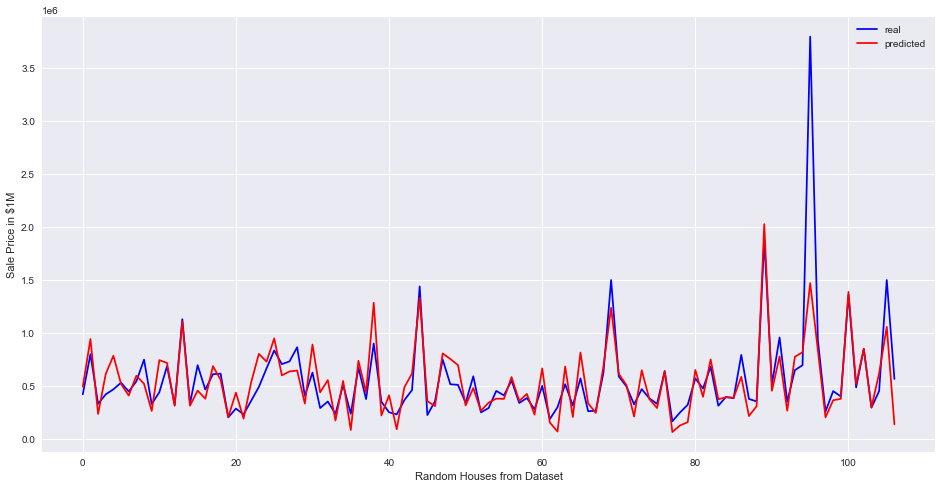

In [150]:
# Testing the model once with a train test split and plotting the real and predicted values for the test data

MSE = []
rkf = RepeatedKFold(n_splits=200, n_repeats=1, random_state=42)
#X_modell3 = X_modell3.values
#y_modell3 = y_modell3.values
for train_index, test_index in rkf.split(X_modell3):
    X_train, X_test = X_modell3[train_index,:], X_modell3[test_index,:]
    y_train, y_test = y_modell3[train_index], y_modell3[test_index]
    
    X_train = sms.add_constant(X_train)
    
    model_Rkfold = sms.OLS(y_train, X_train)
    results_Rkfold = model_Rkfold.fit()
    
    #results_modell3.summary()
    y_true = y_test
    y_pred = results_Rkfold.predict(X_test)
    
    MSE.append(mean_squared_error(y_true, y_pred))
    
print("The RMSE for the model with the chosen parameters has a median of: "\
      + str (round(statistics.median(MSE)**0.5,2))+"$")

plt.figure(figsize=(16,8));
plt.plot(range(0,len(test_index)), y_true, color = "blue");
plt.plot(range(0,len(test_index)), y_pred, color = "red");
plt.xlabel("Random Houses from Dataset");
plt.ylabel("Sale Price in $1M");
plt.legend(["real", "predicted"]);


## Future work

Anything beyond this point is not part of my presentation. It is declared possible future work.

Future work would include a sophisticated feature selection by reducing multicolinearity between the features and dropping coefficients that do not carry any significance (P-value greater than 0.05)

The chapters below are not completed.

### Dropping useless coefficients

In [154]:
coeff_todrop = results_modell3.pvalues.reset_index()
coeff_todrop.columns = ["index","p-value"]
coeff_todrop = coeff_todrop[coeff_todrop["p-value"] > 0.05]["index"]
coeff_todrop.values

array(['zipcode_98002', 'zipcode_98003', 'zipcode_98023', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98038', 'zipcode_98042',
       'zipcode_98092', 'zipcode_98188'], dtype=object)

### Re-running the third model after removing useless coefficients

In [155]:
X_modell3 = pd.get_dummies(df[["sqft_living", "zipcode"]].copy(),
                           drop_first = True)
X_modell3.drop(coeff_todrop.values, axis = 1, inplace = True)
X_modell3 = sms.add_constant(X_modell3)
y_modell3 = df["price"]
model_modell3 = sms.OLS(y_modell3, X_modell3)
results_modell3 = model_modell3.fit()
results_modell3.summary()

/Users/tjadeappel/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     970.6
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        09:45:29   Log-Likelihood:            -2.9226e+05
No. Observations:               21532   AIC:                         5.846e+05
Df Residuals:                   21471   BIC:                         5.851e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.928e+05   4437.474    -43.453      0.000   -2.02e+05   -1.84e+05
sqft_living     252.1176      1.571    160.472      0.000     249.038     255.197
zipcode_98004  8.169e+05   1.13e+04     72.594      0.000    7.95e+05    8.39e+05
zipcode_98005  3.333e+05    1.5e+04     22.149      0.000    3.04e+05    3.63e+05
zipcode_98006  3.245e+05   9211.373     35.233      0.000    3.06e+05    3.43e+05
zipcode_98007  2.599e+05   1.63e+04     15.920      0.000    2.28e+05    2.92e+05
zipcode_98008  3.006e+05   1.17e+04     25.598      0.000    2.78e+05    3.24e+05
zipcode_98010  7.756e+04   1.93e+04      4.023      0.000    3.98e+04    1.15e+05
zipcode_98011  1.152e+05    1.4e+04      8.215      0.000    8.77e+04    1.43e+05
zipcode_98014  1.145e+05   1.74e+04      6.590      0.000    8.04e+04    1.49e+05
zipcode_98019  7.015e+04   1.42e+04      4.955      0.000    4.24e+04    9.79e+04
zipcode_98022  4.619e+04   1.29e+04      3.586      0.000    2.09e+04    7.14e+04
zipcode_98024  1.837e+05   2.16e+04      8.488      0.000    1.41e+05    2.26e+05
zipcode_98027  1.756e+05   9957.626     17.633      0.000    1.56e+05    1.95e+05
zipcode_98028  1.206e+05   1.18e+04     10.252      0.000    9.75e+04    1.44e+05
zipcode_98029  2.296e+05   1.11e+04     20.707      0.000    2.08e+05    2.51e+05
zipcode_98033  3.964e+05   9702.973     40.857      0.000    3.77e+05    4.15e+05
zipcode_98034  2.157e+05   8740.109     24.680      0.000    1.99e+05    2.33e+05
zipcode_98039  1.396e+06   2.72e+04     51.262      0.000    1.34e+06    1.45e+06
zipcode_98040  5.952e+05   1.19e+04     49.816      0.000    5.72e+05    6.19e+05
zipcode_98045   1.11e+05   1.32e+04      8.408      0.000    8.52e+04    1.37e+05
zipcode_98052  2.421e+05   8574.094     28.237      0.000    2.25e+05    2.59e+05
zipcode_98053  2.122e+05   1.01e+04     21.101      0.000    1.93e+05    2.32e+05
zipcode_98055  4.714e+04    1.2e+04      3.914      0.000    2.35e+04    7.07e+04
zipcode_98056  1.052e+05   9988.573     10.534      0.000    8.56e+04    1.25e+05
zipcode_98058  2.971e+04   9471.130      3.137      0.002    1.11e+04    4.83e+04
zipcode_98059  8.044e+04   9367.737      8.587      0.000    6.21e+04    9.88e+04
zipcode_98065   7.23e+04   1.13e+04      6.372      0.000    5.01e+04    9.45e+04
zipcode_98070  2.049e+05   1.79e+04     11.472      0.000     1.7e+05     2.4e+05
zipcode_98072  1.653e+05    1.2e+04     13.781      0.000    1.42e+05    1.89e+05
zipcode_98074  2.113e+05   9660.934     21.874      0.000    1.92e+05     2.3e+05
zipcode_98075  2.231e+05   1.07e+04     20.945      0.000    2.02e+05    2.44e+05
zipcode_98077  1.554e+05   1.39e+04     11.140      0.000    1.28e+05    1.83e+05
zipcode_98102  5.501e+05   1.89e+04     29.082      0.000    5.13e+05    5.87e+05
zipcode_98103  3.616e+05   8400.568     43.047   

### Variance Inflation Factors

In [152]:
# Variance inflation factors for multicolinearity are caluclated and printed in descending order

#from statsmodels.stats.outliers_influence import variance_inflation_factor
#vif = pd.DataFrame()
#vif["VIF_Factor"] = [variance_inflation_factor(X_modell1.values, i) for i in range (X_modell1.shape[1])]
#vif["feature"] = X_modell1.columns
#vif.round(1)
#vif.sort_values(["VIF_Factor"], ascending = False, inplace = True)
#vif